In [7]:
! pip install -q kaggle
from google.colab import files
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                             title                                       size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -----------------------------------------  -----  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                             9KB  2022-10-06 08:55:25          14609        435  1.0              
swaptr/layoffs-2022                                             Layoffs 2022                                29KB  2022-11-16 20:46:46            966         34  1.0              
akshaydattatraykhare/data-for-admission-in-the-university       Data for Admission in the University         4KB  2022-10-27 11:05:45           3375         75  1.0              
aneesayoub/world-universities-ranking-2022   

In [8]:
!kaggle competitions download -c tensorflow-great-barrier-reef
!unzip /content/tensorflow-great-barrier-reef.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_images/video_2/4303.jpg  
  inflating: train_images/video_2/4304.jpg  
  inflating: train_images/video_2/4305.jpg  
  inflating: train_images/video_2/4306.jpg  
  inflating: train_images/video_2/4307.jpg  
  inflating: train_images/video_2/4308.jpg  
  inflating: train_images/video_2/4309.jpg  
  inflating: train_images/video_2/431.jpg  
  inflating: train_images/video_2/4310.jpg  
  inflating: train_images/video_2/4311.jpg  
  inflating: train_images/video_2/4312.jpg  
  inflating: train_images/video_2/4313.jpg  
  inflating: train_images/video_2/4314.jpg  
  inflating: train_images/video_2/4315.jpg  
  inflating: train_images/video_2/4316.jpg  
  inflating: train_images/video_2/4317.jpg  
  inflating: train_images/video_2/4318.jpg  
  inflating: train_images/video_2/4319.jpg  
  inflating: train_images/video_2/432.jpg  
  inflating: train_images/video_2/4320.jpg  
  inflating: train_images/video_2/4321.jpg  
  infl

In [3]:
! mkdir train

# Prepare the data

In [4]:
import pandas as pd
import os
import shutil

In [5]:
# https://blog.csdn.net/wavehaha/article/details/113484407
def clearDirectory(path):
    if not os.path.exists(path):
        os.mkdir(path)
    else:
        shutil.rmtree(path)

In [9]:
# 1.Read train file. split it into train and test files.
trainExcel = pd.read_csv("train.csv")

negImgName = []
posImgName = []

# get all the negative and positive image id
for j in range(len(trainExcel)):
    if trainExcel["annotations"][j] == "[]":
        temp = trainExcel.iloc[j, [4]].to_string().split(' ')
        image_id = temp[-1]
        negImgName.append(image_id)

    else:
        temp = trainExcel.iloc[j, [4]].to_string().split(' ')
        image_id = temp[-1]
        # print(image_id)
        posImgName.append(image_id)

    # choose only video0 for first time train and test
negImgNameVideo0 = []
negImgNameVideo1 = []
negImgNameVideo2 = []
posImgNameVideo0 = []
posImgNameVideo1 = []
posImgNameVideo2 = []

# convenient for split image
for name in negImgName:
    if name[0] == "0":
        negImgNameVideo0.append(name[2:])
    elif name[0] == "1":
        negImgNameVideo1.append(name[2:])
    elif name[0] == "2":
        negImgNameVideo2.append(name[2:])

for name in posImgName:
    if name[0] == "0":
        posImgNameVideo0.append(name[2:])
    elif name[0] == "1":
        posImgNameVideo1.append(name[2:])
    elif name[0] == "2":
        posImgNameVideo2.append(name[2:])

trainNegTarget = "./train/neg"
trainPosTarget = "./train/pos"

clearDirectory(trainNegTarget)
clearDirectory(trainPosTarget)

# do the transfer
for negImage in negImgNameVideo0:
    sourceImg = "./train_images/video_0/" + str(negImage) + ".jpg"
    shutil.copyfile(sourceImg, trainNegTarget + "/" + "0-" + str(negImage) + ".jpg")
for posImage in posImgNameVideo0:
    sourceImg = "./train_images/video_0/" + str(posImage) + ".jpg"
    shutil.copyfile(sourceImg, trainPosTarget + "/" + "0-" + str(posImage) + ".jpg")
for negImage in negImgNameVideo1:
    sourceImg = "./train_images/video_1/" + str(negImage) + ".jpg"
    shutil.copyfile(sourceImg, trainNegTarget + "/" + "1-" + str(negImage) + ".jpg")
for posImage in posImgNameVideo1:
    sourceImg = "./train_images/video_1/" + str(posImage) + ".jpg"
    shutil.copyfile(sourceImg, trainPosTarget + "/" + "1-" + str(posImage) + ".jpg")
for negImage in negImgNameVideo2:
    sourceImg = "./train_images/video_2/" + str(negImage) + ".jpg"
    shutil.copyfile(sourceImg, trainNegTarget + "/" + "2-" + str(negImage) + ".jpg")
for posImage in posImgNameVideo2:
    sourceImg = "./train_images/video_2/" + str(posImage) + ".jpg"
    shutil.copyfile(sourceImg, trainPosTarget + "/" + "2-" + str(posImage) + ".jpg")

# Extract Feature

In [10]:
! mkdir feature32_32

In [11]:
import os
import cv2
import numpy as np
import random
import shutil
from skimage.feature import hog
import glob
import joblib
import sys
import pandas
import re
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

In [12]:
def getBoundingBoxFromCsv(path):
    bboxfile = pandas.read_csv(path)
    bboxDic = {}
    for j in range(len(bboxfile)):
        if bboxfile["annotations"][j] == "[]":
            pass
        else:
            bboxOut = []
            bbox = bboxfile.iloc[j, [5]].tolist()
            temp = re.split("[\\s*$&#/\"'\\,.:;?!\\[\\]{}()<>~\\-_]+", bbox[0])
            temp = [i for i in temp if i != '']
            while len(temp) != 0:
                x = temp[1]
                y = temp[3]
                width = temp[5]
                height = temp[7]
                bboxOut.append((x, y, width, height))
                del temp[0:8]
            image_id = bboxfile.iloc[j, [4]].to_string().split(' ')
            image_id = image_id[-1]
            bboxDic[image_id] = bboxOut
    return bboxDic

In [13]:
# importrant note1: please use x64 version instead x32 version python when running this code
# x32 will lead limit memory usage for extraction of image hog feature64_64
# importrant note2: try to allocate as much as possible RAM (or virtual memory) to pycharm and it`s location disk

trainNegPath = "./train/neg/"
trainPosPath = "./train/pos/"

trainNegFeaturesPath = "./feature32_32/neg"
trainPosFeaturesPath = "./feature32_32/pos"


# https://blog.csdn.net/wavehaha/article/details/113484407



clearDirectory(trainNegFeaturesPath)
clearDirectory(trainPosFeaturesPath)
bboxDic = getBoundingBoxFromCsv("./train.csv")
trainNegImg = glob.glob(trainNegPath + '*.jpg')
trainPosImg = glob.glob(trainPosPath + '*.jpg')


posF = []
negF = []

print("Do PosImg feature32_32 extraction, and with image resize to 640*360(half)")

for posImg in tqdm(trainPosImg):
    posImRead = cv2.imread(posImg)
    posImRead = cv2.resize(posImRead, (640, 360))
    bboxList = bboxDic[posImg.split("/")[3][0:-4]]
    for index in range(len(bboxList)):

        y = round(int(bboxList[index][1])/2)
        x = round(int(bboxList[index][0])/2)
        height = round(int(bboxList[index][3])/2)
        width = round(int(bboxList[index][2])/2)
        bboxImg = posImRead[y:y + height, x:x + width]
        bboxImg = cv2.resize(bboxImg, (32, 32))
        feat = hog(bboxImg, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True)
        featName = os.path.basename(posImg) + "-" + str(index) + '.feature'
        joblib.dump(feat, trainPosFeaturesPath + "/" + featName)

# https://stackoverflow.com/questions/42263020/opencv-trying-to-get-random-portion-of-image
print("Do NegImg feature32_32 extraction")
for negImg in tqdm(trainNegImg):
    temp = cv2.imread(negImg)
    # random crop 1 image in one neg image.
    for i in range(0, 5):
        max_x = temp.shape[1] - 32
        max_y = temp.shape[0] - 32
        x = np.random.randint(0, max_x)
        y = np.random.randint(0, max_y)
        negImRead = temp[y:y + 32,x:x + 32]
        # cv2.imshow("?", negImRead)
        # cv2.waitKey(0)
        feat = hog(negImRead, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True)
        featName = os.path.basename(negImg) + "_" + str(i) + '.feature'
        joblib.dump(feat, trainNegFeaturesPath + "/" + featName)
#

Do PosImg feature32_32 extraction, and with image resize to 640*360(half)


100%|██████████| 4919/4919 [02:28<00:00, 33.08it/s]


Do NegImg feature32_32 extraction


100%|██████████| 18582/18582 [10:42<00:00, 28.94it/s]


In [15]:
testLen = glob.glob("/content/feature32_32/pos/" + '*.feature')
print(len(testLen))

11898


# Train the model(without hard example) and split some of images into test set


In [16]:
import glob
import random
import shutil
import joblib
from tqdm import tqdm
from sklearn.svm import LinearSVC
from os.path import exists
import os

In [21]:
! mkdir test
! mkdir model

mkdir: cannot create directory ‘model’: File exists


In [18]:
#clearDirectory("./test/")

In [22]:
trainNegFeaturesPath = "./feature32_32/neg/"
trainPosFeaturesPath = "./feature32_32/pos/"
testPath = "./test"

negFeatList = glob.glob(trainNegFeaturesPath + '*.feature')
posFeatList = glob.glob(trainPosFeaturesPath + '*.feature')


trainNegFeatList = random.sample(negFeatList, 90000)
# total 11898 bbox (features), choose 80% for train.
trainPosFeatList = random.sample(posFeatList, 9500)

for image in tqdm(negFeatList):
  #print(type(image))
  if image not in trainNegFeatList:
    #print("1")
    sourceImg = "./train/neg/" + os.path.basename(image)[0:-10]
    file_exists = exists("./test/" + os.path.basename(image)[0:-10])
    if not file_exists:
      #print("3")
      sourceImg = sourceImg.strip("-")
      shutil.copyfile(sourceImg, "./test/" +os.path.basename(image)[0:-10])
                           
for image in tqdm(posFeatList):
  if image not in trainPosFeatList:
    sourceImg = "./train/pos/" + os.path.basename(image)[0:-10]
    file_exists = exists("./test/" + os.path.basename(image)[0:-10])
    if not file_exists:
      sourceImg = sourceImg.strip("-")
      shutil.copyfile(sourceImg, "./test/" +os.path.basename(image)[0:-10])

# remember change model name when you change any number in the script
modelPath = "./model/svmWindow32_32_8822_90000Neg_9500Pos_unweight.model"
features = []
labels = []


# trying to capture positive features which has lower amounts
clf = LinearSVC(max_iter=100000)
print("load negFeatures")
for feat in tqdm(trainNegFeatList):
    feat_neg_data = joblib.load(feat)
    features.append(feat_neg_data)
    labels.append(0)

print("load posFeatures")
for feat in tqdm(trainPosFeatList):
    feat_pos_data = joblib.load(feat)
    features.append(feat_pos_data)
    labels.append(1)

clf.fit(features, labels)
joblib.dump(clf, modelPath)

100%|██████████| 11898/11898 [00:12<00:00, 973.03it/s] 


load negFeatures


100%|██████████| 90000/90000 [00:57<00:00, 1568.34it/s]


load posFeatures


100%|██████████| 9500/9500 [00:06<00:00, 1379.63it/s]


['./model/svmWindow32_32_8822_90000Neg_9500Pos_unweight.model']

# Test for no hard example model

In [23]:
import random
import joblib
import os
import glob
from skimage.feature import hog
from skimage.transform import pyramid_gaussian
import cv2
import pandas
import re
import copy
from tqdm import tqdm
import warnings
from google.colab.patches import cv2_imshow

In [30]:
# https://blog.csdn.net/submarineas/article/details/124512591
def sliding_window(image, window_size, step_size):
    for row in range(0, image.shape[0], step_size[0]):
        for col in range(0, image.shape[1], step_size[1]):
            yield (row, col, image[row:row + window_size[0], col:col + window_size[1]])

def overlapping_area(detection_1, detection_2):
    x1_rect1 = detection_1[0] # x top left
    x1_rect2 = detection_2[0] 
    x2_rect1 = detection_1[0] + detection_1[2] # x bottom right
    x2_rect2 = detection_2[0] + detection_2[2] 
    y1_rect1 = detection_1[1] # y top left
    y1_rect2 = detection_2[1] 
    y2_rect1 = detection_1[1] + detection_1[3] # y bottom right
    y2_rect2 = detection_2[1] + detection_2[3] 
    # Calculate the overlapping Area
    x_overlap = max(0, min(x2_rect1, x2_rect2)-max(x1_rect1, x1_rect2))
    y_overlap = max(0, min(y2_rect1, y2_rect2)-max(y1_rect1, y1_rect2))
    overlap_area = x_overlap * y_overlap
    area_1 = detection_1[2] * detection_2[3]
    area_2 = detection_2[2] * detection_2[3]
    total_area = area_1 + area_2 - overlap_area
    return overlap_area / float(total_area)
  
# detection will be given as (col, row, width, height,prob)
def nms(detections,threshold):
  # nothing find in detections, return empty list
  if len(detections) == 0:
      return []
  # assume highest confidence detection to be a right one
  sorted(detections, key=lambda x: x[4], reverse=True)
  out = [detections[0]]
  del detections[0]

  # detect the overlapping area for each of rest bounding box with all bbox already in out
  for i,detection in enumerate(detections):
    flag = True
    for outBbox in out:
      if overlapping_area(detection,outBbox) > threshold:
        flag = False
        del detections[i]
        break
    if flag:
      out.append(detection)
      del detections[i]
  return out

Please select visualize or not (suggest do visualization for only one image test), enter YES or NO: YES


  0%|          | 0/1 [00:00<?, ?it/s]

600 156 40 40
485 10 32 32
410 145 32 32
390 235 32 32
360 215 32 32
359 23 50 50
332 156 62 62
325 262 40 40
315 5 32 32
275 140 32 32
270 95 32 32
250 125 32 32
235 285 32 32
220 110 32 32
205 60 32 32
175 130 32 32
125 31 50 50
87 0 40 40
80 290 32 32
68 48 62 62
45 100 32 32
31 243 40 40
25 290 32 32
15 5 32 32


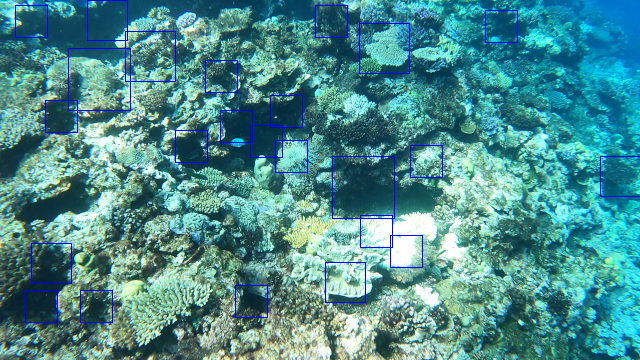

100%|██████████| 1/1 [00:12<00:00, 12.80s/it]

current iou is: 0.3 _____________
highestIOU change to 0.17777777777777778
highestIOU change to 0.033715441672285906
highestIOU change to 0.2925714285714286
highestIOU change to 0.08022922636103152
current iou is: 0.35 _____________
highestIOU change to 0.17777777777777778
highestIOU change to 0.033715441672285906
highestIOU change to 0.2925714285714286
highestIOU change to 0.08022922636103152
current iou is: 0.4 _____________
highestIOU change to 0.17777777777777778
highestIOU change to 0.033715441672285906
highestIOU change to 0.2925714285714286
highestIOU change to 0.08022922636103152
current iou is: 0.45 _____________
highestIOU change to 0.17777777777777778
highestIOU change to 0.033715441672285906
highestIOU change to 0.2925714285714286
highestIOU change to 0.08022922636103152
current iou is: 0.5 _____________
highestIOU change to 0.17777777777777778
highestIOU change to 0.033715441672285906
highestIOU change to 0.2925714285714286
highestIOU change to 0.08022922636103152
current 

In [32]:
visualLizeOrNot = input("Please select visualize or not (suggest do visualization for only one image test), enter YES or NO: ")
if visualLizeOrNot == "YES":
  visualLize = True
else:
  visualLize = False

warnings.filterwarnings("ignore")

bboxDic = getBoundingBoxFromCsv("./train.csv")
clf = joblib.load("/content/model/svmWindow32_32_8822_90000Neg_9500Pos_unweight.model")
test_image_path = "./test/"
testImList = glob.glob(test_image_path + '*.jpg')

# random test 50 image
testImList = random.sample(testImList, 30)

# set the same window size with feautre extraction
window_size = (32, 32)
step_size = (5, 5)

F2ForTestSet = 0
PrecisionForTestSet = 0
RecallForTestSet = 0

# uncomment this line if u want to test a single image 
testImList = ["./train/pos/0-53.jpg"]

# https://github.com/SamPlvs/Object-detection-via-HOG-SVM/blob/master/testing_HOG_SVM.py
for test_image in tqdm(testImList):
  detections = []
  #print(bboxDic[os.path.basename(test_image)[0:-4]])
  test_image_read = cv2.imread(test_image, cv2.IMREAD_GRAYSCALE)
  #cv2_imshow(test_image_read)
  test_image_read = cv2.resize(test_image_read, (640, 360))
  #cv2_imshow(test_image_read)
  scale = 0
  downscale = 1.25

  for test_image_pyramid in pyramid_gaussian(test_image_read, downscale=downscale):
    if test_image_pyramid.shape[0] < window_size[0] or test_image_pyramid.shape[1] < window_size[1]:
      break
    for (row, col, window) in sliding_window(test_image_pyramid, window_size, step_size):
      if window.shape != window_size:
        continue
      sliding_image_hog = hog(window, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True)
      sliding_image_hog = sliding_image_hog.reshape(1, -1)
      pred = clf.predict(sliding_image_hog)
      if pred == 1:
        pred_prob = clf.decision_function(sliding_image_hog)
        (window_height, window_width) = window_size
        detections.append((int(col * downscale ** scale), int(row * downscale ** scale), int(window_width * downscale ** scale),int(window_height * downscale ** scale),pred_prob))  
    scale += 1

  detections = sorted(detections, key=lambda x: x[4], reverse=True)
  #print(len(detections))
  detections_nms = nms(detections, threshold=0.1)
  detections_nms = sorted(detections_nms, key=lambda x: x[0], reverse=True)
  #print(len(detections_nms))

  # visualize---------------------------
  if visualLize:
    test_image_detect = cv2.imread(test_image)
    test_image_detect = cv2.resize(test_image_detect, (640, 360))
    for detect in detections_nms:
        x = detect[0]
        y = detect[1]
        width = detect[2]
        height = detect[3]
        print(x, y, width, height)
        cv2.rectangle(test_image_detect, pt1=(x, y), pt2=(x + width, y + height), color=(255, 0, 0), thickness=1)
    cv2_imshow(test_image_detect)
  #print(detections_nms)
  # end of visualize-----------------------

  # calculate F2
  # if nothing in detections
  if len(detections_nms) == 0:
    try:
      # if something in groundTruth
      bboxList = copy.deepcopy(bboxDic[os.path.basename(test_image)[0:-4]])
      # now we need to regard all box in groundTruth as FN
      F2Final = 0
      Recall = 0
      Precision = 0
      F2ForTestSet += F2Final
      print('nothing in detection but something in groundTruth')
    except KeyError:
      # nothing in predict and groundTruth
      F2Final = 1
      F2ForTestSet += F2Final
      PrecisionFinal = 1
      PrecisionForTestSet += PrecisionFinal
      RecallFinal = 1
      RecallForTestSet += RecallFinal
      print('nothing in detection and nothing in groundTruth')

  else:
    # if something in predict
    F2 = 0
    Precision = 0
    Recall = 0
    for iou in [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]:
      TP = 0
      FN = 0
      FP = 0
      try:
        print("current iou is: "+ str(iou)+" _____________")
        # if something in groundTruth and predict
        bboxList = copy.deepcopy(bboxDic[os.path.basename(test_image)[0:-4]])
        #print(bboxList)
        realTrue = len(bboxList)
        matched = {}
        for i in range(len(bboxList)):
          #print(bboxList[i])
          #print(str(bboxList[i]))
          matched[str(bboxList[i])] = False
        #print(matched.keys())
        # for each bbox 
        for detection in detections_nms:
          highestIOU = [0, ""]
          for bbox in range(len(bboxList)):
            if matched[str(bboxList[bbox])] == False:
              temp = [int(k)/2 for k in bboxList[bbox]]
              IOU = overlapping_area(detection[0:4], temp)
              if IOU > highestIOU[0]:
                highestIOU = [IOU, str(bboxList[bbox])]
                #highestIOU = [IOU, bboxList[bbox]]
                print("highestIOU change to " + str(IOU))
              pass
            if highestIOU != 0:
              if matched.get(highestIOU[1]):
                matched[highestIOU[1]] = True
                print("matched")
              else:
                pass
            
          if highestIOU[0] > iou :
            
            TP += 1
          else:
            FP += 1
        for i in bboxList:
          FN += 1
        F2 += 5 * TP / (5 * TP + 4 * FN + FP)
        Precision += TP / (TP + FP)
        Recall += TP / realTrue
      except KeyError:
        # Annotation has no bbox, but we detect it. marked as FP
        bboxList = []
        F2 = 0
        Precision = 0
        Recall = 0
        print('something in detection and nothing in groundTruth')
        break
    PrecisionFinal = Precision / 11
    RecallFinal = Recall / 11
    F2Final = F2 / 11
    F2ForTestSet += F2Final
    PrecisionForTestSet += PrecisionFinal
    RecallForTestSet += RecallFinal

F2ForTestSet = F2ForTestSet / len(testImList)
PrecisionForTestSet = PrecisionForTestSet / len(testImList)
RecallForTestSet = RecallForTestSet / len(testImList)
print("F2 score is: " + str(F2ForTestSet))
#print("Precision score is: " + str(PrecisionForTestSet))
#print("Recall score is: " + str(RecallForTestSet))



# Extract Hard Example

In [26]:
clf = joblib.load("./model/svmWindow32_32_8822_90000Neg_9500Pos_unweight.model")

trainHardImagePath = "./train/neg/"
trainHardPath = "./feature32_32/hard/"

negImgList = glob.glob(trainHardImagePath + '*.jpg')

negImgList = random.sample(negImgList, 1000)
window_size = (32, 32)
step_size = (5, 5)

clearDirectory(trainHardPath)
for image in tqdm(negImgList):
    test_image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    test_image = cv2.resize(test_image, (640, 360))
    scale = 0
    detections = []
    downscale = 1.25
    index = 0
    for test_image_pyramid in pyramid_gaussian(test_image, downscale=downscale):
        if test_image_pyramid.shape[0] < window_size[0] or test_image_pyramid.shape[1] < window_size[1]:
            break
        for (row, col, sliding_image) in sliding_window(test_image_pyramid, window_size, step_size):
            if sliding_image.shape != window_size:
                continue
            if index == 10:
                break
            sliding_image_hog = hog(sliding_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True)
            copyOfHog = copy.deepcopy(sliding_image_hog)
            sliding_image_hog = sliding_image_hog.reshape(1, -1)
            pred = clf.predict(sliding_image_hog)
            if pred == 1:
                index += 1
                featName = os.path.basename(image) + "-" + "hard" + "-" + str(index) + '.feature'
                joblib.dump(copyOfHog, trainHardPath + "/" + featName)

        scale += 1
    if index == 0:
        print("detect nothing in "+str(os.path.basename(image)))


100%|██████████| 1000/1000 [29:57<00:00,  1.80s/it]


# Train with hard example

In [27]:
trainNegFeaturesPath = "./feature32_32/neg/"
trainPosFeaturesPath = "./feature32_32/pos/"
trainHardFeaturePath = "./feature32_32/hard/"

negFeatList = glob.glob(trainNegFeaturesPath + '*.feature')
posFeatList = glob.glob(trainPosFeaturesPath + '*.feature')
hardFeatList = glob.glob(trainHardFeaturePath + '*.feature')

# total 11898 bbox (features), choose 80% for train.
trainNegFeatList = random.sample(negFeatList, 90000)
# total 11898 bbox (features), choose 80% for train.
trainPosFeatList = random.sample(posFeatList, 9500)
trainHardFeatList = random.sample(hardFeatList, 3500)

modelPath = "./model/svmWindow32_32_8822_3500hard_90000Neg_9500Pos_unweight.model"
features = []
labels = []


# trying to capture positive features which has lower amounts
clf = LinearSVC(max_iter=100000)
print("load negFeatures")
for feat in tqdm(trainNegFeatList):
    feat_neg_data = joblib.load(feat)
    features.append(feat_neg_data)
    labels.append(0)

print("load posFeatures")
for feat in tqdm(trainPosFeatList):
    feat_pos_data = joblib.load(feat)
    features.append(feat_pos_data)
    labels.append(1)

print("load hardFeatures")
for feat in tqdm(trainHardFeatList):
    feat_hard_data = joblib.load(feat)
    features.append(feat_hard_data)
    labels.append(0)
clf.fit(features, labels)
joblib.dump(clf, modelPath)


load negFeatures


100%|██████████| 90000/90000 [00:18<00:00, 4865.67it/s]


load posFeatures


100%|██████████| 9500/9500 [00:01<00:00, 4799.79it/s]


load hardFeatures


100%|██████████| 3500/3500 [00:00<00:00, 5324.19it/s]


['./model/svmWindow32_32_8822_3500hard_90000Neg_9500Pos_unweight.model']

# Test with hard example model

In [29]:
visualLizeOrNot = input("Please select visualize or not (suggest do visualization for only one image test), enter YES or NO: ")
if visualLizeOrNot == "YES":
  visualLize = True
else:
  visualLize = False

warnings.filterwarnings("ignore")

bboxDic = getBoundingBoxFromCsv("./train.csv")
clf = joblib.load("./model/svmWindow32_32_8822_3500hard_90000Neg_9500Pos_unweight.model")
test_image_path = "./test/"
testImList = glob.glob(test_image_path + '*.jpg')

# random test 50 image
testImList = random.sample(testImList, 50)

# set the same window size with feautre extraction
window_size = (32, 32)
step_size = (5, 5)

F2ForTestSet = 0
PrecisionForTestSet = 0
RecallForTestSet = 0

# uncomment this line if u want to test a single image 
#testImList = ["./train/pos/0-53.jpg","./train/pos/0-54.jpg","./train/pos/0-56.jpg","./train/pos/0-63.jpg","./train/pos/0-23.jpg"]

# https://github.com/SamPlvs/Object-detection-via-HOG-SVM/blob/master/testing_HOG_SVM.py
for test_image in tqdm(testImList):
  detections = []
  #print(bboxDic[os.path.basename(test_image)[0:-4]])
  test_image_read = cv2.imread(test_image, cv2.IMREAD_GRAYSCALE)
  #cv2_imshow(test_image_read)
  test_image_read = cv2.resize(test_image_read, (640, 360))
  #cv2_imshow(test_image_read)
  scale = 0
  downscale = 1.25

  for test_image_pyramid in pyramid_gaussian(test_image_read, downscale=downscale):
    if test_image_pyramid.shape[0] < window_size[0] or test_image_pyramid.shape[1] < window_size[1]:
      break
    for (row, col, window) in sliding_window(test_image_pyramid, window_size, step_size):
      if window.shape != window_size:
        continue
      sliding_image_hog = hog(window, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True)
      sliding_image_hog = sliding_image_hog.reshape(1, -1)
      pred = clf.predict(sliding_image_hog)
      if pred == 1:
        pred_prob = clf.decision_function(sliding_image_hog)
        (window_height, window_width) = window_size
        detections.append((int(col * downscale ** scale), int(row * downscale ** scale), int(window_width * downscale ** scale),int(window_height * downscale ** scale),pred_prob))  
    scale += 1

  detections = sorted(detections, key=lambda x: x[4], reverse=True)
  #print(len(detections))
  detections_nms = nms(detections, threshold=0.25)
  detections_nms = sorted(detections_nms, key=lambda x: x[0], reverse=True)
  #print(len(detections_nms))

  # visualize---------------------------
  if visualLize:
    test_image_detect = cv2.imread(test_image)
    test_image_detect = cv2.resize(test_image_detect, (640, 360))
    for detect in detections_nms:
        x = detect[0]
        y = detect[1]
        width = detect[2]
        height = detect[3]
        print(x, y, width, height)
        cv2.rectangle(test_image_detect, pt1=(x, y), pt2=(x + width, y + height), color=(255, 0, 0), thickness=1)
    cv2_imshow(test_image_detect)
  #print(detections_nms)
  # end of visualize-----------------------

  # calculate F2
  # if nothing in detections
  if len(detections_nms) == 0:
    try:
      # if something in groundTruth
      bboxList = copy.deepcopy(bboxDic[os.path.basename(test_image)[0:-4]])
      # now we need to regard all box in groundTruth as FN
      F2Final = 0
      Recall = 0
      Precision = 0
      F2ForTestSet += F2Final
      print('nothing in detection but something in groundTruth')
    except KeyError:
      # nothing in predict and groundTruth
      F2Final = 1
      F2ForTestSet += F2Final
      PrecisionFinal = 1
      PrecisionForTestSet += PrecisionFinal
      RecallFinal = 1
      RecallForTestSet += RecallFinal
      print('nothing in detection and nothing in groundTruth')

  else:
    # if something in predict
    F2 = 0
    Precision = 0
    Recall = 0
    for iou in [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]:
      TP = 0
      FN = 0
      FP = 0
      try:
        print("current iou is: "+ str(iou)+" _____________")
        # if something in groundTruth and predict
        bboxList = copy.deepcopy(bboxDic[os.path.basename(test_image)[0:-4]])
        #print(bboxList)
        realTrue = len(bboxList)
        matched = {}
        for i in range(len(bboxList)):
          #print(bboxList[i])
          #print(str(bboxList[i]))
          matched[str(bboxList[i])] = False
        #print(matched.keys())
        # for each bbox 
        for detection in detections_nms:
          highestIOU = [0, ""]
          for bbox in range(len(bboxList)):
            if matched[str(bboxList[bbox])] == False:
              temp = [int(k)/2 for k in bboxList[bbox]]
              IOU = overlapping_area(detection[0:4], temp)
              if IOU > highestIOU[0]:
                highestIOU = [IOU, str(bboxList[bbox])]
                #highestIOU = [IOU, bboxList[bbox]]
                #print("highestIOU change to " + str(IOU))
              pass
            if highestIOU != 0:
              if matched.get(highestIOU[1]):
                matched[highestIOU[1]] = True
                print("matched")
              else:
                pass
            
          if highestIOU[0] > iou :
            print("TP+1")
            TP += 1
          else:
            FP += 1
        for i in bboxList:
          FN += 1
        F2 += 5 * TP / (5 * TP + 4 * FN + FP)
        print(F2)
        Precision += TP / (TP + FP)
        Recall += TP / realTrue
      except KeyError:
        # Annotation has no bbox, but we detect it. marked as FP
        bboxList = []
        F2 = 0
        Precision = 0
        Recall = 0
        print('something in detection and nothing in groundTruth')
        break
    PrecisionFinal = Precision / 11
    RecallFinal = Recall / 11
    F2Final = F2 / 11
    F2ForTestSet += F2Final
    PrecisionForTestSet += PrecisionFinal
    RecallForTestSet += RecallFinal
    print("F2 FINAL IS " + str(F2Final))
F2ForTestSet = F2ForTestSet / len(testImList)
PrecisionForTestSet = PrecisionForTestSet / len(testImList)
RecallForTestSet = RecallForTestSet / len(testImList)
print("F2 score is: " + str(F2ForTestSet))
#print("Precision score is: " + str(PrecisionForTestSet))
#print("Recall score is: " + str(RecallForTestSet))


Please select visualize or not (suggest do visualization for only one image test), enter YES or NO: 


  2%|▏         | 1/50 [00:12<10:07, 12.40s/it]

current iou is: 0.3 _____________
something in detection and nothing in groundTruth
F2 FINAL IS 0.0


  4%|▍         | 2/50 [00:27<11:07, 13.90s/it]

nothing in detection and nothing in groundTruth


  6%|▌         | 3/50 [00:39<10:21, 13.23s/it]

current iou is: 0.3 _____________
something in detection and nothing in groundTruth
F2 FINAL IS 0.0


  8%|▊         | 4/50 [00:52<09:52, 12.88s/it]

current iou is: 0.3 _____________
0.0
current iou is: 0.35 _____________
0.0
current iou is: 0.4 _____________
0.0
current iou is: 0.45 _____________
0.0
current iou is: 0.5 _____________
0.0
current iou is: 0.55 _____________
0.0
current iou is: 0.6 _____________
0.0
current iou is: 0.65 _____________
0.0
current iou is: 0.7 _____________
0.0
current iou is: 0.75 _____________
0.0
current iou is: 0.8 _____________
0.0
F2 FINAL IS 0.0


 10%|█         | 5/50 [01:04<09:33, 12.75s/it]

current iou is: 0.3 _____________
something in detection and nothing in groundTruth
F2 FINAL IS 0.0


 12%|█▏        | 6/50 [01:18<09:32, 13.02s/it]

current iou is: 0.3 _____________
something in detection and nothing in groundTruth
F2 FINAL IS 0.0


 14%|█▍        | 7/50 [01:30<09:10, 12.80s/it]

current iou is: 0.3 _____________
0.0
current iou is: 0.35 _____________
0.0
current iou is: 0.4 _____________
0.0
current iou is: 0.45 _____________
0.0
current iou is: 0.5 _____________
0.0
current iou is: 0.55 _____________
0.0
current iou is: 0.6 _____________
0.0
current iou is: 0.65 _____________
0.0
current iou is: 0.7 _____________
0.0
current iou is: 0.75 _____________
0.0
current iou is: 0.8 _____________
0.0
F2 FINAL IS 0.0


 16%|█▌        | 8/50 [01:42<08:52, 12.69s/it]

current iou is: 0.3 _____________
0.0
current iou is: 0.35 _____________
0.0
current iou is: 0.4 _____________
0.0
current iou is: 0.45 _____________
0.0
current iou is: 0.5 _____________
0.0
current iou is: 0.55 _____________
0.0
current iou is: 0.6 _____________
0.0
current iou is: 0.65 _____________
0.0
current iou is: 0.7 _____________
0.0
current iou is: 0.75 _____________
0.0
current iou is: 0.8 _____________
0.0
F2 FINAL IS 0.0


 18%|█▊        | 9/50 [01:55<08:37, 12.61s/it]

current iou is: 0.3 _____________
0.0
current iou is: 0.35 _____________
0.0
current iou is: 0.4 _____________
0.0
current iou is: 0.45 _____________
0.0
current iou is: 0.5 _____________
0.0
current iou is: 0.55 _____________
0.0
current iou is: 0.6 _____________
0.0
current iou is: 0.65 _____________
0.0
current iou is: 0.7 _____________
0.0
current iou is: 0.75 _____________
0.0
current iou is: 0.8 _____________
0.0
F2 FINAL IS 0.0


 20%|██        | 10/50 [02:08<08:36, 12.90s/it]

current iou is: 0.3 _____________
something in detection and nothing in groundTruth
F2 FINAL IS 0.0


 22%|██▏       | 11/50 [02:21<08:17, 12.77s/it]

current iou is: 0.3 _____________
something in detection and nothing in groundTruth
F2 FINAL IS 0.0


 24%|██▍       | 12/50 [02:34<08:03, 12.73s/it]

current iou is: 0.3 _____________
something in detection and nothing in groundTruth
F2 FINAL IS 0.0


 26%|██▌       | 13/50 [02:46<07:48, 12.66s/it]

current iou is: 0.3 _____________
0.0
current iou is: 0.35 _____________
0.0
current iou is: 0.4 _____________
0.0
current iou is: 0.45 _____________
0.0
current iou is: 0.5 _____________
0.0
current iou is: 0.55 _____________
0.0
current iou is: 0.6 _____________
0.0
current iou is: 0.65 _____________
0.0
current iou is: 0.7 _____________
0.0
current iou is: 0.75 _____________
0.0
current iou is: 0.8 _____________
0.0
F2 FINAL IS 0.0


 28%|██▊       | 14/50 [03:00<07:46, 12.96s/it]

current iou is: 0.3 _____________
something in detection and nothing in groundTruth
F2 FINAL IS 0.0


 30%|███       | 15/50 [03:12<07:27, 12.79s/it]

current iou is: 0.3 _____________
something in detection and nothing in groundTruth
F2 FINAL IS 0.0


 32%|███▏      | 16/50 [03:25<07:12, 12.71s/it]

nothing in detection and nothing in groundTruth


 34%|███▍      | 17/50 [03:38<07:08, 12.99s/it]

nothing in detection and nothing in groundTruth


 36%|███▌      | 18/50 [03:52<07:02, 13.19s/it]

current iou is: 0.3 _____________
something in detection and nothing in groundTruth
F2 FINAL IS 0.0


 38%|███▊      | 19/50 [04:04<06:42, 12.99s/it]

current iou is: 0.3 _____________
something in detection and nothing in groundTruth
F2 FINAL IS 0.0


 40%|████      | 20/50 [04:17<06:23, 12.78s/it]

current iou is: 0.3 _____________
something in detection and nothing in groundTruth
F2 FINAL IS 0.0


 42%|████▏     | 21/50 [04:29<06:07, 12.67s/it]

current iou is: 0.3 _____________
0.0
current iou is: 0.35 _____________
0.0
current iou is: 0.4 _____________
0.0
current iou is: 0.45 _____________
0.0
current iou is: 0.5 _____________
0.0
current iou is: 0.55 _____________
0.0
current iou is: 0.6 _____________
0.0
current iou is: 0.65 _____________
0.0
current iou is: 0.7 _____________
0.0
current iou is: 0.75 _____________
0.0
current iou is: 0.8 _____________
0.0
F2 FINAL IS 0.0


 44%|████▍     | 22/50 [04:43<06:02, 12.96s/it]

current iou is: 0.3 _____________
something in detection and nothing in groundTruth
F2 FINAL IS 0.0


 46%|████▌     | 23/50 [04:55<05:45, 12.81s/it]

current iou is: 0.3 _____________
something in detection and nothing in groundTruth
F2 FINAL IS 0.0


 48%|████▊     | 24/50 [05:08<05:31, 12.73s/it]

current iou is: 0.3 _____________
something in detection and nothing in groundTruth
F2 FINAL IS 0.0


 50%|█████     | 25/50 [05:20<05:16, 12.66s/it]

nothing in detection and nothing in groundTruth


 52%|█████▏    | 26/50 [05:34<05:10, 12.95s/it]

nothing in detection and nothing in groundTruth


 54%|█████▍    | 27/50 [05:46<04:53, 12.78s/it]

current iou is: 0.3 _____________
0.0
current iou is: 0.35 _____________
0.0
current iou is: 0.4 _____________
0.0
current iou is: 0.45 _____________
0.0
current iou is: 0.5 _____________
0.0
current iou is: 0.55 _____________
0.0
current iou is: 0.6 _____________
0.0
current iou is: 0.65 _____________
0.0
current iou is: 0.7 _____________
0.0
current iou is: 0.75 _____________
0.0
current iou is: 0.8 _____________
0.0
F2 FINAL IS 0.0


 56%|█████▌    | 28/50 [05:59<04:38, 12.65s/it]

current iou is: 0.3 _____________
something in detection and nothing in groundTruth
F2 FINAL IS 0.0


 58%|█████▊    | 29/50 [06:11<04:23, 12.57s/it]

current iou is: 0.3 _____________
something in detection and nothing in groundTruth
F2 FINAL IS 0.0


 60%|██████    | 30/50 [06:25<04:17, 12.87s/it]

current iou is: 0.3 _____________
0.0
current iou is: 0.35 _____________
0.0
current iou is: 0.4 _____________
0.0
current iou is: 0.45 _____________
0.0
current iou is: 0.5 _____________
0.0
current iou is: 0.55 _____________
0.0
current iou is: 0.6 _____________
0.0
current iou is: 0.65 _____________
0.0
current iou is: 0.7 _____________
0.0
current iou is: 0.75 _____________
0.0
current iou is: 0.8 _____________
0.0
F2 FINAL IS 0.0


 62%|██████▏   | 31/50 [06:37<04:03, 12.81s/it]

current iou is: 0.3 _____________
something in detection and nothing in groundTruth
F2 FINAL IS 0.0


 64%|██████▍   | 32/50 [06:50<03:47, 12.67s/it]

current iou is: 0.3 _____________
something in detection and nothing in groundTruth
F2 FINAL IS 0.0


 66%|██████▌   | 33/50 [07:03<03:40, 12.95s/it]

current iou is: 0.3 _____________
something in detection and nothing in groundTruth
F2 FINAL IS 0.0


 68%|██████▊   | 34/50 [07:17<03:29, 13.07s/it]

current iou is: 0.3 _____________
something in detection and nothing in groundTruth
F2 FINAL IS 0.0


 70%|███████   | 35/50 [07:29<03:14, 12.94s/it]

current iou is: 0.3 _____________
0.0
current iou is: 0.35 _____________
0.0
current iou is: 0.4 _____________
0.0
current iou is: 0.45 _____________
0.0
current iou is: 0.5 _____________
0.0
current iou is: 0.55 _____________
0.0
current iou is: 0.6 _____________
0.0
current iou is: 0.65 _____________
0.0
current iou is: 0.7 _____________
0.0
current iou is: 0.75 _____________
0.0
current iou is: 0.8 _____________
0.0
F2 FINAL IS 0.0


 72%|███████▏  | 36/50 [07:42<02:59, 12.80s/it]

current iou is: 0.3 _____________
0.0
current iou is: 0.35 _____________
0.0
current iou is: 0.4 _____________
0.0
current iou is: 0.45 _____________
0.0
current iou is: 0.5 _____________
0.0
current iou is: 0.55 _____________
0.0
current iou is: 0.6 _____________
0.0
current iou is: 0.65 _____________
0.0
current iou is: 0.7 _____________
0.0
current iou is: 0.75 _____________
0.0
current iou is: 0.8 _____________
0.0
F2 FINAL IS 0.0


 74%|███████▍  | 37/50 [07:54<02:45, 12.71s/it]

current iou is: 0.3 _____________
something in detection and nothing in groundTruth
F2 FINAL IS 0.0


 76%|███████▌  | 38/50 [08:07<02:33, 12.78s/it]

current iou is: 0.3 _____________
0.0
current iou is: 0.35 _____________
0.0
current iou is: 0.4 _____________
0.0
current iou is: 0.45 _____________
0.0
current iou is: 0.5 _____________
0.0
current iou is: 0.55 _____________
0.0
current iou is: 0.6 _____________
0.0
current iou is: 0.65 _____________
0.0
current iou is: 0.7 _____________
0.0
current iou is: 0.75 _____________
0.0
current iou is: 0.8 _____________
0.0
F2 FINAL IS 0.0


 78%|███████▊  | 39/50 [08:20<02:21, 12.90s/it]

current iou is: 0.3 _____________
0.0
current iou is: 0.35 _____________
0.0
current iou is: 0.4 _____________
0.0
current iou is: 0.45 _____________
0.0
current iou is: 0.5 _____________
0.0
current iou is: 0.55 _____________
0.0
current iou is: 0.6 _____________
0.0
current iou is: 0.65 _____________
0.0
current iou is: 0.7 _____________
0.0
current iou is: 0.75 _____________
0.0
current iou is: 0.8 _____________
0.0
F2 FINAL IS 0.0


 80%|████████  | 40/50 [08:33<02:07, 12.75s/it]

current iou is: 0.3 _____________
something in detection and nothing in groundTruth
F2 FINAL IS 0.0


 82%|████████▏ | 41/50 [08:46<01:55, 12.84s/it]

nothing in detection but something in groundTruth


 84%|████████▍ | 42/50 [08:59<01:43, 12.96s/it]

current iou is: 0.3 _____________
something in detection and nothing in groundTruth
F2 FINAL IS 0.0


 86%|████████▌ | 43/50 [09:12<01:30, 12.96s/it]

current iou is: 0.3 _____________
something in detection and nothing in groundTruth
F2 FINAL IS 0.0


 88%|████████▊ | 44/50 [09:24<01:16, 12.77s/it]

current iou is: 0.3 _____________
something in detection and nothing in groundTruth
F2 FINAL IS 0.0


 90%|█████████ | 45/50 [09:37<01:03, 12.71s/it]

current iou is: 0.3 _____________
0.0
current iou is: 0.35 _____________
0.0
current iou is: 0.4 _____________
0.0
current iou is: 0.45 _____________
0.0
current iou is: 0.5 _____________
0.0
current iou is: 0.55 _____________
0.0
current iou is: 0.6 _____________
0.0
current iou is: 0.65 _____________
0.0
current iou is: 0.7 _____________
0.0
current iou is: 0.75 _____________
0.0
current iou is: 0.8 _____________
0.0
F2 FINAL IS 0.0


 92%|█████████▏| 46/50 [09:50<00:51, 12.94s/it]

current iou is: 0.3 _____________
0.0
current iou is: 0.35 _____________
0.0
current iou is: 0.4 _____________
0.0
current iou is: 0.45 _____________
0.0
current iou is: 0.5 _____________
0.0
current iou is: 0.55 _____________
0.0
current iou is: 0.6 _____________
0.0
current iou is: 0.65 _____________
0.0
current iou is: 0.7 _____________
0.0
current iou is: 0.75 _____________
0.0
current iou is: 0.8 _____________
0.0
F2 FINAL IS 0.0


 94%|█████████▍| 47/50 [10:03<00:38, 12.82s/it]

current iou is: 0.3 _____________
0.0
current iou is: 0.35 _____________
0.0
current iou is: 0.4 _____________
0.0
current iou is: 0.45 _____________
0.0
current iou is: 0.5 _____________
0.0
current iou is: 0.55 _____________
0.0
current iou is: 0.6 _____________
0.0
current iou is: 0.65 _____________
0.0
current iou is: 0.7 _____________
0.0
current iou is: 0.75 _____________
0.0
current iou is: 0.8 _____________
0.0
F2 FINAL IS 0.0


 96%|█████████▌| 48/50 [10:15<00:25, 12.69s/it]

current iou is: 0.3 _____________
0.0
current iou is: 0.35 _____________
0.0
current iou is: 0.4 _____________
0.0
current iou is: 0.45 _____________
0.0
current iou is: 0.5 _____________
0.0
current iou is: 0.55 _____________
0.0
current iou is: 0.6 _____________
0.0
current iou is: 0.65 _____________
0.0
current iou is: 0.7 _____________
0.0
current iou is: 0.75 _____________
0.0
current iou is: 0.8 _____________
0.0
F2 FINAL IS 0.0


 98%|█████████▊| 49/50 [10:29<00:12, 12.98s/it]

current iou is: 0.3 _____________
0.0
current iou is: 0.35 _____________
0.0
current iou is: 0.4 _____________
0.0
current iou is: 0.45 _____________
0.0
current iou is: 0.5 _____________
0.0
current iou is: 0.55 _____________
0.0
current iou is: 0.6 _____________
0.0
current iou is: 0.65 _____________
0.0
current iou is: 0.7 _____________
0.0
current iou is: 0.75 _____________
0.0
current iou is: 0.8 _____________
0.0
F2 FINAL IS 0.0


100%|██████████| 50/50 [10:42<00:00, 12.86s/it]

current iou is: 0.3 _____________
0.0
current iou is: 0.35 _____________
0.0
current iou is: 0.4 _____________
0.0
current iou is: 0.45 _____________
0.0
current iou is: 0.5 _____________
0.0
current iou is: 0.55 _____________
0.0
current iou is: 0.6 _____________
0.0
current iou is: 0.65 _____________
0.0
current iou is: 0.7 _____________
0.0
current iou is: 0.75 _____________
0.0
current iou is: 0.8 _____________
0.0
F2 FINAL IS 0.0
F2 score is: 0.1
